In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set directory path
import os
os.chdir("/content/drive/My Drive/COMP-5800-YDK-2020_Group1/ImputedDataset")

## Importing libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [4]:
demoData = pd.read_csv('DemographicsData.csv')
dietData = pd.read_csv('DietaryData.csv')
examData = pd.read_csv('ExaminationData.csv')
labData = pd.read_csv('LaboratoryData.csv')
hypertensionData = pd.read_csv('HypertensionData.csv')

In [5]:
data = demoData.merge(dietData, how = 'outer').merge(examData, how = 'outer').merge(labData, how = 'outer').merge(hypertensionData, how = 'outer')

In [6]:
data = data.fillna(0)

In [7]:
data.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,DMDBORN4,DMDCITZN,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,DSDCOUNT,DSDANCNT,DSD010,DSD010AN,DSQ128A,DSQ128B,DSQ128C,DSQ128D,DSQ128E,DSQ128F,...,DRUG_TOPICAL STEROIDS - UNSPECIFIED,DRUG_TOPIRAMATE,DRUG_TORSEMIDE,DRUG_TRAMADOL,DRUG_TRAVOPROST OPHTHALMIC,DRUG_TRAZODONE,DRUG_TREPROSTINIL,DRUG_TRETINOIN,DRUG_TRETINOIN TOPICAL,DRUG_TRIAMCINOLONE,DRUG_TRIAMCINOLONE TOPICAL,DRUG_TRIAMTERENE,DRUG_TRIHEXYPHENIDYL,DRUG_TRIMETHOBENZAMIDE,DRUG_TRIMETHOPRIM,DRUG_TRIPTORELIN,DRUG_TROSPIUM,DRUG_UMECLIDINIUM,DRUG_UMECLIDINIUM; VILANTEROL,DRUG_UREA TOPICAL,DRUG_URSODIOL,DRUG_USTEKINUMAB,DRUG_Unknown,DRUG_VALACYCLOVIR,DRUG_VALGANCICLOVIR,DRUG_VALPROIC ACID,DRUG_VALSARTAN,DRUG_VARENICLINE,DRUG_VENLAFAXINE,DRUG_VERAPAMIL,DRUG_VILAZODONE,DRUG_VORTIOXETINE,DRUG_WARFARIN,DRUG_ZAFIRLUKAST,DRUG_ZALEPLON,DRUG_ZIDOVUDINE,DRUG_ZIPRASIDONE,DRUG_ZOLPIDEM,DRUG_ZONISAMIDE,Target
0,93703.0,10.0,2.0,2.0,2.0,5.0,6.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,5.0,5.0,3.000000e+00,5.397605e-79,5.397605e-79,1.0,2.0,3.0,1.0,9246.491865,8539.731348,2.0,145.0,15.0,15.0,1.000000e+00,5.397605e-79,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,93704.0,10.0,2.0,1.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,4.0,4.0,2.000000e+00,5.397605e-79,5.397605e-79,1.0,2.0,3.0,1.0,37338.768343,42566.614750,1.0,143.0,15.0,15.0,5.397605e-79,5.397605e-79,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,93705.0,10.0,2.0,2.0,66.0,4.0,4.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,5.397605e-79,5.397605e-79,1.000000e+00,2.0,4.0,1.0,2.0,8614.571172,8338.419786,2.0,145.0,3.0,3.0,8.000000e+00,5.397605e-79,1.0,2.0,10.0,0.0,0.0,13.0,14.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,93706.0,10.0,2.0,1.0,18.0,5.0,6.0,1.0,1.0,1.0,2.0,2.0,1.4,2.0,1.8,5.0,5.0,5.397605e-79,5.397605e-79,1.000000e+00,1.0,4.0,3.0,1.0,8548.632619,8723.439814,2.0,134.0,6.6,6.6,5.397605e-79,5.397605e-79,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,93707.0,10.0,2.0,1.0,13.0,5.0,7.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,7.0,7.0,5.397605e-79,3.000000e+00,5.397605e-79,1.0,3.0,2.0,1.0,6769.344567,7064.609730,1.0,138.0,10.0,10.0,5.397605e-79,5.397605e-79,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
data.to_csv(r'FinalData.csv', index = False, header=True)

In [9]:
data['Target'].value_counts()

0    6794
1    1572
Name: Target, dtype: int64

In [10]:
# Store the accuracies for all the models.
df = pd.DataFrame(columns=['Model', 'Accuracy']);

## Removing Outliers

In [11]:
from sklearn.ensemble import IsolationForest
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

clf = IsolationForest(max_samples=100, random_state=42)
output_outlier = pd.DataFrame(clf.fit_predict(data))
# data.drop(output_outlier.loc[output_outlier[0] == -1].index, inplace=True)
data['Target'].value_counts()

0    6794
1    1572
Name: Target, dtype: int64

In [12]:
output_outlier[output_outlier[0] == -1].index

Int64Index([4309, 4421, 6937, 7758, 8044], dtype='int64')

In [13]:
data.iloc[[341, 552, 1239, 1442, 1984, 2237]]

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,DMDBORN4,DMDCITZN,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,DSDCOUNT,DSDANCNT,DSD010,DSD010AN,DSQ128A,DSQ128B,DSQ128C,DSQ128D,DSQ128E,DSQ128F,...,DRUG_TOPICAL STEROIDS - UNSPECIFIED,DRUG_TOPIRAMATE,DRUG_TORSEMIDE,DRUG_TRAMADOL,DRUG_TRAVOPROST OPHTHALMIC,DRUG_TRAZODONE,DRUG_TREPROSTINIL,DRUG_TRETINOIN,DRUG_TRETINOIN TOPICAL,DRUG_TRIAMCINOLONE,DRUG_TRIAMCINOLONE TOPICAL,DRUG_TRIAMTERENE,DRUG_TRIHEXYPHENIDYL,DRUG_TRIMETHOBENZAMIDE,DRUG_TRIMETHOPRIM,DRUG_TRIPTORELIN,DRUG_TROSPIUM,DRUG_UMECLIDINIUM,DRUG_UMECLIDINIUM; VILANTEROL,DRUG_UREA TOPICAL,DRUG_URSODIOL,DRUG_USTEKINUMAB,DRUG_Unknown,DRUG_VALACYCLOVIR,DRUG_VALGANCICLOVIR,DRUG_VALPROIC ACID,DRUG_VALSARTAN,DRUG_VARENICLINE,DRUG_VENLAFAXINE,DRUG_VERAPAMIL,DRUG_VILAZODONE,DRUG_VORTIOXETINE,DRUG_WARFARIN,DRUG_ZAFIRLUKAST,DRUG_ZALEPLON,DRUG_ZIDOVUDINE,DRUG_ZIPRASIDONE,DRUG_ZOLPIDEM,DRUG_ZONISAMIDE,Target
341,94074.0,10.0,2.0,1.0,29.0,3.0,3.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,5.397605e-79,5.397605e-79,5.397605e-79,1.0,2.0,2.0,2.0,151719.438619,169951.021741,2.0,142.0,15.0,10.0,5.397605e-79,5.397605e-79,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
552,94307.0,10.0,2.0,2.0,10.0,3.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,6.0,6.0,2.000000e+00,2.000000e+00,5.397605e-79,2.0,2.0,2.0,1.0,14171.565061,15490.183508,1.0,142.0,9.0,9.0,5.397605e-79,5.397605e-79,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1239,95071.0,10.0,2.0,2.0,38.0,3.0,3.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,6.0,6.0,1.000000e+00,3.000000e+00,5.397605e-79,1.0,3.0,3.0,1.0,42347.022565,48210.314324,1.0,143.0,3.0,3.0,2.000000e+00,5.397605e-79,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1442,95293.0,10.0,2.0,1.0,16.0,3.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,6.0,6.0,1.000000e+00,3.000000e+00,5.397605e-79,1.0,3.0,3.0,1.0,28133.072743,29953.155104,1.0,143.0,3.0,3.0,5.397605e-79,5.397605e-79,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1984,95886.0,10.0,2.0,2.0,57.0,5.0,6.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,5.0,5.0,1.000000e+00,5.397605e-79,5.397605e-79,1.0,3.0,1.0,1.0,15447.147813,15533.088113,1.0,136.0,99.0,99.0,5.397605e-79,5.397605e-79,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2237,96165.0,10.0,2.0,2.0,64.0,5.0,6.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,3.0,5.397605e-79,5.397605e-79,3.000000e+00,2.0,4.0,1.0,1.0,11959.677825,12306.957620,1.0,137.0,4.0,4.0,5.397605e-79,5.397605e-79,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [14]:
sorted(data)

Q1=data.quantile(0.25)
Q3=data.quantile(0.75)
IQR=Q3-Q1
print(IQR)

SEQN                4626.5
SDDSRVYR               0.0
RIDSTATR               0.0
RIAGENDR               1.0
RIDAGEYR              47.0
                     ...  
DRUG_ZIDOVUDINE        0.0
DRUG_ZIPRASIDONE       0.0
DRUG_ZOLPIDEM          0.0
DRUG_ZONISAMIDE        0.0
Target                 0.0
Length: 1064, dtype: float64


In [15]:
ol = (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))

In [16]:
(ol.sum(axis=1) > 35).value_counts()

False    7697
True      669
dtype: int64

In [17]:
bl = (ol.sum(axis=1) > 35)

In [18]:
bl[bl == True]

2       True
8       True
17      True
34      True
52      True
        ... 
8339    True
8350    True
8354    True
8357    True
8365    True
Length: 669, dtype: bool

## Train-Test Split with Stratified Sampling for Logistic Regression and Random Forest.

In [19]:
X = data.drop('Target', axis = 1)
y = data['Target']

Logistic Regression is generally used for binary classification and a basic machine learning linear algorithm. After stratified sampling, we tried to get the results with logistic regression without applying any feature extraction or any other kind of cross validation.

In [20]:
X_train_strata, X_test_strata, y_train_strata, y_test_strata = train_test_split(X , y, test_size=0.33, random_state=42, stratify = y)
lrmodel_strata = LogisticRegression(C = 0.00001, max_iter = 8500)
lrmodel_strata.fit(X_train_strata, y_train_strata)
lrpred_strata = lrmodel_strata.predict(X_test_strata)

In [21]:
df = df.append({'Model': 'Logistic with Stratified Sampling', 'Accuracy': accuracy_score(y_test_strata, lrpred_strata)}, ignore_index=True)

In [22]:
accuracy_score(y_test_strata, lrpred_strata)

0.8478812024628758

In [23]:
confusion_matrix(y_test_strata,lrpred_strata)

array([[2138,  104],
       [ 316,  203]])

In [24]:
print(classification_report(y_test_strata,lrpred_strata))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2242
           1       0.66      0.39      0.49       519

    accuracy                           0.85      2761
   macro avg       0.77      0.67      0.70      2761
weighted avg       0.83      0.85      0.83      2761



In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rfc = RandomForestClassifier(n_estimators = 150, max_depth = 50, oob_score = True)
# rfc = RandomForestClassifier()
rfc.fit(X_train_strata, y_train_strata)
rfc_pred = rfc.predict(X_test_strata)
accuracy_score(y_test_strata, rfc_pred)

0.91017747193046

In [27]:
confusion_matrix(y_test_strata,rfc_pred)

array([[2147,   95],
       [ 153,  366]])

In [28]:
print(classification_report(y_test_strata,rfc_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2242
           1       0.79      0.71      0.75       519

    accuracy                           0.91      2761
   macro avg       0.86      0.83      0.85      2761
weighted avg       0.91      0.91      0.91      2761



## Handling Class Imbalance with Random Upsampling

In [29]:
train, test = train_test_split(data, test_size=0.33, random_state=42)

In [30]:
train['Target'].value_counts()

0    4558
1    1047
Name: Target, dtype: int64

In [31]:
data_majority = train[train['Target'] == 0]
data_minority = train[train['Target'] == 1]

In [32]:
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=4558,    # to match majority class
                                 random_state=42) # reproducible results
# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled])

X_train = data_upsampled.drop('Target', axis = 1)
y_train = data_upsampled['Target']
X_test= test.drop('Target', axis = 1)
y_test = test['Target']

In [33]:
lrmodel = LogisticRegression(C = 0.000001, max_iter=8000)
lrmodel.fit(X_train, y_train)
lrpred = lrmodel.predict(X_test)
lrpred_prob = lrmodel.predict_proba(X_test)

In [34]:
df = df.append({'Model': 'Logistic with Random Upsampling', 'Accuracy': accuracy_score(y_test, lrpred)}, ignore_index=True)

In [35]:
accuracy_score(y_test, lrpred)

0.8275986961245926

In [36]:
confusion_matrix(y_test,lrpred)

array([[1841,  395],
       [  81,  444]])

In [37]:
print(classification_report(y_test,lrpred))

              precision    recall  f1-score   support

           0       0.96      0.82      0.89      2236
           1       0.53      0.85      0.65       525

    accuracy                           0.83      2761
   macro avg       0.74      0.83      0.77      2761
weighted avg       0.88      0.83      0.84      2761



## Application of Dimensionality Reduction Technique: LDA, PCA

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

In [39]:
label_dict = {1: 'yes', 0: 'no'}

In [40]:
def plot_scikit_lda(Xtr, title):

    ax = plt.subplot(111)
    for label,color in zip(range(0,2),('blue', 'red')):

        plt.plot(Xtr[:,0][y_train == label] * -1,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

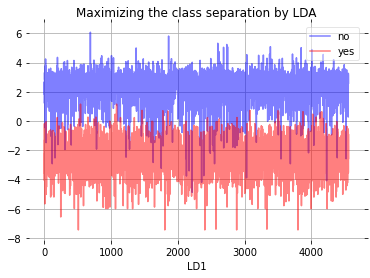

In [41]:
# plot_step_lda()
plot_scikit_lda(X_train_lda, title='Maximizing the class separation by LDA')

In [42]:
lrmodel_lda = LogisticRegression()
lrmodel_lda.fit(X_train_lda, y_train)
lrpred_lda = lrmodel_lda.predict(X_train_lda)
lrpred_lda = lrmodel_lda.predict(X_test_lda)
lrpred_prob_lda = lrmodel_lda.predict_proba(X_test_lda)

In [43]:
accuracy_score(y_test, lrpred_lda)

0.9362549800796812

In [44]:
confusion_matrix(y_test,lrpred_lda)

array([[2132,  104],
       [  72,  453]])

In [45]:
# Let's find the features that were high weight while calculating the LDA vector.
# LDA takes the componenet as minimum of n_classes - 1 and features.

In [46]:
np.where(lda.coef_ > 20)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]),
 array([ 142,  154,  220,  222,  224,  324,  326,  336,  338,  342,  370,
         379,  380,  384,  435,  439,  448,  706,  708,  881,  950, 1005,
        1012]))

In [47]:
# All variables are related to the high blood pressure and cholestrol
# LBXRBCSI: Red blood cell count
# `: Insulin
# LBDINLC: Insulin comment code
# LBXIRN: Iron frozen, Serum
# LBDBGELC: Mercury, ethyl comment code
# LBXSC3SI: Bicarbonate 
# LBXSGB: Globulin
# LBXSKSI: Potassium
# LBXSCH: Total Cholesterol, refrigerated serum

In [48]:
data.columns[np.where(lda.coef_ > 20)[1]]

Index(['OHX08RTC', 'OHX22RTC', 'LBDTCSI', 'LBDBCRSI', 'LBXBCO', 'LBDBCDSI',
       'LBXTHG', 'LBDIHGSI', 'LBXBGE', 'LBDBGMSI', 'LBDSPHSI', 'LBDSCHSI',
       'LBXSTP', 'LBXSUA', 'DRUG_AMLODIPINE; VALSARTAN', 'DRUG_AMPHETAMINE',
       'DRUG_ANTIHYPERTENSIVE AGENTS - UNSPECIFIED', 'DRUG_FLUVASTATIN',
       'DRUG_FORMOTEROL', 'DRUG_NISOLDIPINE', 'DRUG_QUINAPRIL',
       'DRUG_TELMISARTAN', 'DRUG_TERIPARATIDE'],
      dtype='object')

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
rfc = RandomForestClassifier(n_estimators = 150, max_depth = 50, oob_score = True)
# rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
accuracy_score(y_test, rfc_pred)

0.8975009054690329

In [51]:
confusion_matrix(y_test, rfc_pred)

array([[2055,  181],
       [ 102,  423]])

In [52]:
np.where(rfc.feature_importances_ > 0.008)

(array([  4,  19,  21,  76,  94, 192, 194, 197, 198, 201, 203, 204, 205,
        207, 209, 291, 399, 400, 431, 817, 851]),)

In [53]:
data.columns[np.where(rfc.feature_importances_ > 0.008)]

Index(['RIDAGEYR', 'DMDHHSZE', 'DMDHRAGZ', 'BMXWT', 'OHX18CTC', 'OHX02SE',
       'OHX04SE', 'OHX10SE', 'OHX12SE', 'OHX15SE', 'OHX19SE', 'OHX20SE',
       'OHX21SE', 'OHX29SE', 'OHX31SE', 'LBXGH', 'RXQSEEN', 'RXDDAYS',
       'DRUG_AMLODIPINE', 'DRUG_LISINOPRIL', 'DRUG_METOPROLOL'],
      dtype='object')

In [54]:
estimator = rfc.estimators_[0]
estimator

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1201033466, splitter='best')

In [55]:
from sklearn.tree import export_graphviz

# Export as dot file
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = X.columns,
                class_names = 'Target',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [56]:
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

In [57]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Output hidden; open in https://colab.research.google.com to view.

In [58]:
df = df.append({'Model': 'Logistic with LDA', 'Accuracy': accuracy_score(y_test, lrpred_lda)}, ignore_index=True)

## PCA with Logistic Regression and Random Forest

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

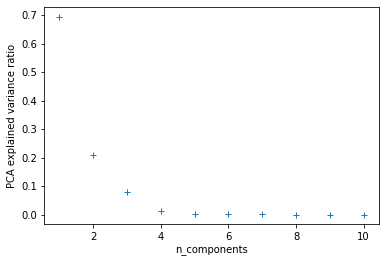

In [60]:
plt.plot(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, '+', linewidth=2)
plt.ylabel('PCA explained variance ratio')
plt.xlabel('n_components')
plt.show()

Logistic Regression with PCA with optimal value 5.

In [61]:
pca = PCA(n_components = 3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

lrmodel_pca = LogisticRegression()
lrmodel_pca.fit(X_train_pca, y_train)
lrpred_pca = lrmodel_pca.predict(X_test_pca)
lrpred_prob_pca = lrmodel_pca.predict_proba(X_test_pca)

In [62]:
df = df.append({'Model': 'Logistic with PCA', 'Accuracy': accuracy_score(y_test, lrpred_pca)}, ignore_index=True)

In [63]:
accuracy_score(y_test, lrpred_pca)

0.4241216950380297

In [64]:
confusion_matrix(y_test,lrpred_pca)

array([[ 769, 1467],
       [ 123,  402]])

In [65]:
print(classification_report(y_test,lrpred_pca))

              precision    recall  f1-score   support

           0       0.86      0.34      0.49      2236
           1       0.22      0.77      0.34       525

    accuracy                           0.42      2761
   macro avg       0.54      0.55      0.41      2761
weighted avg       0.74      0.42      0.46      2761



## Area Under ROC Implementation

In [66]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, lrpred_prob[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, lrpred_prob_pca[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, lrpred_prob_lda[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [67]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, lrpred_prob[:,1])
auc_score2 = roc_auc_score(y_test, lrpred_prob_pca[:,1])
auc_score3 = roc_auc_score(y_test, lrpred_prob_lda[:,1])

print(auc_score1, auc_score2, auc_score3)

0.9104259306584889 0.5460533265184427 0.9590765823323963


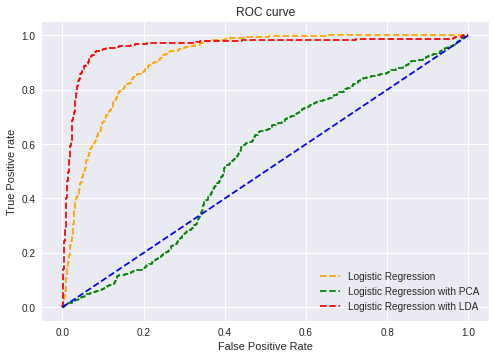

In [68]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Logistic Regression with PCA')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='Logistic Regression with LDA')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

## Cross Validation with traditional classification models using LDA, PCA

In [69]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [70]:
def get_score(model, X, y, numFold, modelName, df):
  y_pred = cross_val_predict(model, X, y, cv = numFold)
  finalScore = accuracy_score(y, y_pred)
  df = df.append({'Model':modelName,'Accuracy':finalScore}, ignore_index=True)
  print(modelName)
  print(accuracy_score(y, y_pred))
  print(confusion_matrix(y, y_pred))
  return finalScore, df

In [71]:
lrScores, df = get_score(LogisticRegression(C=0.00001, max_iter=8000), X, y, 5, 'Logistic with CV', df)
ldaLrScores, df = get_score(make_pipeline(LinearDiscriminantAnalysis(),LogisticRegression(C=0.00001, max_iter=8000)), X, y, 5, 'Logistic with CV using LDA', df)
pcaLrScores, df = get_score(make_pipeline(PCA(n_components = 5),LogisticRegression(C=0.00001, max_iter=8000)), X, y, 5, 'Logistic with CV using PCA', df)

Logistic with CV
0.854769304327038
[[6466  328]
 [ 887  685]]
Logistic with CV using LDA
0.8120965814009085
[[6794    0]
 [1572    0]]
Logistic with CV using PCA
0.8429356920870189
[[6228  566]
 [ 748  824]]


In [72]:
rfScores, df = get_score(RandomForestClassifier(), X, y, 5, 'Random Forest with CV', df)
ldaRfScores, df = get_score(make_pipeline(LinearDiscriminantAnalysis(),RandomForestClassifier()), X, y, 5, 'Random Forest with CV using LDA', df)
pcaRfScores, df = get_score(make_pipeline(PCA(n_components = 5),RandomForestClassifier()), X, y, 5, 'Random Forest with CV using PCA', df)

Random Forest with CV
0.9224240975376524
[[6523  271]
 [ 378 1194]]
Random Forest with CV using LDA
0.9399952187425293
[[6552  242]
 [ 260 1312]]
Random Forest with CV using PCA
0.8442505378914654
[[6183  611]
 [ 692  880]]


In [73]:
df.sort_values(['Accuracy'])

,Model,Accuracy
3,Logistic with PCA,0.424122
5,Logistic with CV using LDA,0.812097
1,Logistic with Random Upsampling,0.827599
6,Logistic with CV using PCA,0.842936
9,Random Forest with CV using PCA,0.844251
0,Logistic with Stratified Sampling,0.847881
4,Logistic with CV,0.854769
7,Random Forest with CV,0.922424
2,Logistic with LDA,0.936255
8,Random Forest with CV using LDA,0.939995


##Application of Synthetic Minority Oversampling Technique (SMOTE)

To compare the corresponding results with Random upsampling.

In [74]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from numpy import where

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.33, random_state=42)

In [76]:
counter = Counter(y_train)
print(counter)

Counter({0: 4558, 1: 1047})


In [77]:
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [78]:
counter = Counter(y_train_smote)
print(counter)

Counter({0: 4558, 1: 4558})


In [79]:
lrmodel_smote = LogisticRegression(C = 0.00001, max_iter = 8000)
lrmodel_smote.fit(X_train_smote, y_train_smote)
lrpred_smote = lrmodel_smote.predict(X_test)

In [80]:
accuracy_score(y_test,lrpred_smote)

0.8138355668236147

In [81]:
confusion_matrix(y_test,lrpred_smote)

array([[1803,  433],
       [  81,  444]])

In [82]:
rfc_grid_smote = RandomForestClassifier()

In [83]:
from sklearn.model_selection import RandomizedSearchCV

In [84]:
#############Hyperparameters to be tuned using random search###############

# Number of trees in random forest
n_estimators = [int(x) for x in range(20,100,10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

In [85]:
rf_random = RandomizedSearchCV(estimator = rfc_grid_smote, param_distributions = random_grid, n_iter = 15, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_smote,y_train_smote)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [86]:
rfc_smote = rf_random.predict(X_test)

In [87]:
accuracy_score(y_test, rfc_smote)

0.8989496559217675

In [88]:
confusion_matrix(y_test, rfc_smote)

array([[2048,  188],
       [  91,  434]])